## Install packages

In [1]:
!pip install -q gymnasium[classic-control]


## Import and create cartpole

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

env = gym.make("CartPole-v1")
obs, info = env.reset(seed=0)

print("Obs shape:", obs.shape)
print("Action space:", env.action_space)


Obs shape: (4,)
Action space: Discrete(2)


## Rendering in Colab

(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

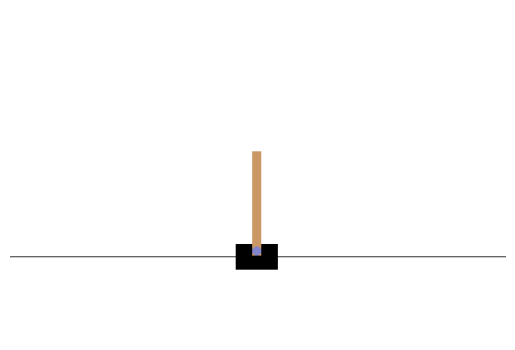

In [3]:
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset()

frame = env.render()
plt.imshow(frame)
plt.axis("off")


In [41]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

env.reset(seed=seed)
env.action_space.seed(seed)


0

## REINFORCE

In [64]:
class PolicyNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(4, 128)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(128, 2)
    self.stack = nn.Sequential(self.fc1, self.relu, self.fc2)
  def forward(self, x):
    x =  self.stack(x)
    return x

In [79]:
from torch.distributions import Categorical

def run_episode(env, initial_state, model, max_steps: int) :
  state = initial_state
  log_probs = []
  rewards = []
  for t in range(max_steps):
    action_probs = model(torch.tensor(state, dtype=torch.float32))
    dist = Categorical(logits = action_probs)
    action = dist.sample()
    log_prob = dist.log_prob(action)

    next_state, reward, terminated, truncated, _ = env.step(action.item())

    log_probs.append(log_prob)
    rewards.append(reward)
    state = next_state
    if terminated or truncated:
      break
  return log_probs, rewards

def get_expected_return (rewards, gamma, standardize):
  G = 0.0
  returns = []
  for r in reversed(rewards):
      G = r + gamma * G
      returns.append(G)
  returns.reverse()
  returns = torch.tensor(returns, dtype=torch.float32)

  if len(returns) > 1:
      returns = (returns - returns.mean()) / (returns.std() + 1e-8)
  return returns


In [80]:
import numpy as np

import torch.optim as optim


env = gym.make("CartPole-v1")
model = PolicyNetwork()
optimizer = optim.Adam(model.parameters() , lr = 1e-2)

gamma = 0.99
beta = 0.01
episode_returns = []


for ep in range(1000) :
  obs, info = env.reset(seed = None)
  log_probs, rewards = run_episode(env, obs, model, max_steps = 500)

  returns = get_expected_return(rewards, gamma, standardize = True)
  log_probs = torch.stack(log_probs)

  loss = -(log_probs * returns).sum()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ep_ret = float(sum(rewards))
  episode_returns.append(ep_ret)
  avg100 = np.mean(episode_returns[-100:])
  if (ep + 1) % 10 == 0:
    print(f"ep {ep+1:4d} | return {ep_ret:6.1f} | avg100 {avg100:6.1f} | loss {loss.item():8.3f}")

  if avg100 >= 475:
    print("Solved CartPole-v1.")
    break

ep   10 | return   48.0 | avg100   32.7 | loss   -1.650
ep   20 | return   57.0 | avg100   42.6 | loss   -0.301
ep   30 | return   42.0 | avg100   57.4 | loss   -1.184
ep   40 | return   95.0 | avg100   64.2 | loss   -0.999
ep   50 | return   56.0 | avg100   59.6 | loss    0.156
ep   60 | return  130.0 | avg100   73.1 | loss    2.025
ep   70 | return  157.0 | avg100   78.6 | loss    6.266
ep   80 | return  251.0 | avg100   84.9 | loss    1.741
ep   90 | return   42.0 | avg100   90.5 | loss    4.113
ep  100 | return  257.0 | avg100   91.2 | loss    3.876
ep  110 | return  283.0 | avg100  112.0 | loss   -4.573
ep  120 | return  500.0 | avg100  142.2 | loss    5.195
ep  130 | return  370.0 | avg100  172.3 | loss   -9.152
ep  140 | return  104.0 | avg100  183.9 | loss   -4.031
ep  150 | return   29.0 | avg100  183.1 | loss    1.486
ep  160 | return   28.0 | avg100  172.0 | loss   -0.393
ep  170 | return   33.0 | avg100  163.8 | loss   -0.700
ep  180 | return   54.0 | avg100  154.6 | loss  

## REINFORCE + baseline

In [84]:
class ValueNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(4, 128), nn.ReLU(), nn.Linear(128, 1))
  def forward(self, x):
    return self.net(x).squeeze(-1)

def run_episode_with_states(env, model, max_steps: int) :
  state, info = env.reset()
  states = []
  log_probs = []
  rewards = []
  for t in range(max_steps):
    action_probs = model(torch.tensor(state, dtype=torch.float32))
    dist = Categorical(logits = action_probs)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    states.append(state)
    next_state, reward, terminated, truncated, _ = env.step(action.item())

    log_probs.append(log_prob)
    rewards.append(reward)
    state = next_state
    if terminated or truncated:
      break
  return states, log_probs, rewards

In [85]:
from torch._C import Value
import numpy as np

import torch.optim as optim


env = gym.make("CartPole-v1")
value_model = ValueNetwork()
model = PolicyNetwork()
policy_opt = optim.Adam(model.parameters() , lr = 1e-2)
value_opt = optim.Adam(value_model.parameters() , lr = 1e-3)
gamma = 0.99

episode_returns = []


for ep in range(1000) :
  states, log_probs, rewards = run_episode_with_states(env, model, max_steps = 500)

  returns = get_expected_return(rewards, gamma, standardize = True)
  log_probs = torch.stack(log_probs)
  values = value_model(torch.tensor(np.array(states), dtype=torch.float32))
  advantages = returns - values.detach()

  loss = -(log_probs * advantages).sum() + 0.5 * (values - returns).pow(2).sum()

  policy_opt.zero_grad()
  value_opt.zero_grad()
  loss.backward()
  policy_opt.step()
  value_opt.step()

  ep_ret = float(sum(rewards))
  episode_returns.append(ep_ret)
  avg100 = np.mean(episode_returns[-100:])
  if (ep + 1) % 10 == 0:
    print(f"ep {ep+1:4d} | return {ep_ret:6.1f} | avg100 {avg100:6.1f} | loss {loss.item():8.3f}")

  if avg100 >= 475:
    print("Solved CartPole-v1.")
    break

ep   10 | return   27.0 | avg100   23.3 | loss   15.686
ep   20 | return   57.0 | avg100   27.2 | loss   32.612
ep   30 | return   54.0 | avg100   33.2 | loss   26.165
ep   40 | return   61.0 | avg100   34.1 | loss   29.405
ep   50 | return  157.0 | avg100   40.5 | loss   74.093
ep   60 | return   73.0 | avg100   54.0 | loss   29.636
ep   70 | return  232.0 | avg100   63.1 | loss  118.291
ep   80 | return  500.0 | avg100  103.2 | loss  207.547
ep   90 | return  335.0 | avg100  143.6 | loss   80.308
ep  100 | return  500.0 | avg100  168.2 | loss  111.555
ep  110 | return  500.0 | avg100  215.9 | loss  209.530
ep  120 | return  194.0 | avg100  253.6 | loss   72.549
ep  130 | return  246.0 | avg100  265.0 | loss   59.902
ep  140 | return   81.0 | avg100  293.1 | loss   31.792
ep  150 | return  411.0 | avg100  313.6 | loss  165.892
ep  160 | return  500.0 | avg100  351.5 | loss  216.774
ep  170 | return  500.0 | avg100  389.7 | loss  215.924
ep  180 | return  500.0 | avg100  401.1 | loss  

## Actor critic